# 3. 평가
### 분류의 평가 지표 
- 정확도(Accuracy)
- 오차행렬(Confusion Matrix)
- 정밀도(Precision)
- 재현율(Recall)
- F1 스코어
- ROC AUC

분류; 결정 크래스 값 종류 유형에 따라 <b>이진 분류/멀티 분류</b>로 나뉨<br>
위의 분류 성능 지표는 이진 분류에서 더 중유하게 강조하는 지표.

# 정확도(Accuracy)
- 정확도 = 예측 결과가 동일한 데이터 건수/전체 예측 데이터 건수
- 실제 데이터에서 예측 데이터가 얼마나 같은지 판단하는 지표
- 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만으로 성능을 평가하지 않음

In [4]:
#Base Estimator: Estimator를 개발자가 생성할 수 있음
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    #Sex 피처가 1이면 0, 아니면 1
    def predict(self, X):
        pred = np.zeros((X.shape[0]), 1)
        
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
                
        return pred 

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Null 처리
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

정확도는 불균형한(imbalanced) 레이블 값 분포에서 ML 모델 성능을 판단할 경우, 적합한 평가 지표가 아니다.<br>
ex) 100개의 데이터 중 90개의 데이터 레이블이 0이고 10개의 데이터 레이블이 1이면 무조건 0으로 예측해도 정확도는 90%<br>

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    
    def predict(self,X):
        return np.zeros( (len(X), 1) , dtype=bool)

digits = load_digits()

#불균형한 데이터 세트 준비
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split( digits.data, y, random_state=11)

In [7]:
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

fakeclf = MyFakeClassifier()
fakeclf.fit(X_train , y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test , fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


# 오차 행렬
<b> confusion_matrix()</b><br>
학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지 보여주는 지표<br>
- 4분면의 좌, 우는 예측 클래스의 Negative(0)와 Positive(1)로, 상, 하는 실제 클래스의 N/T로 나타낸다
- ex) TN은 실제 클래스 값과 예측 클래스 값이 Negative로 일치
- 출력된 오차 행렬은 ndarray
- 값을 조합해 Classifier의 성능을 측정하는 정확도, 정밀도, 재현율 값을 알 수 있음
- 정확도 = TN+TP / TN+TP+FP+FN

정확도 지표는 비대칭한 데이터 세트에서 Negative에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는 수치적인 판단 오류를 일으키게 된다.

In [8]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

# 정확도와 재현율
Positiv 데이터 세트의 예측 성능에 초점을 맞춘 평가 지표<br>

- 정밀도 = TP / (FP+TP)
- 재현율 = TP / (FN+TP)

<br>

<b>정밀도</b>(양성 예측도)
- precision_score()
- 예측을 Positiv로 한 대상 중에 예측과 실제 값이 Positiv로 일치한 데이터의 비율
- FP를 낮추는 데 초점
- ex) 스팸메일 여부(정상 메일을 스팸으로 처리하면 문제)

<br>

<b>재현율</b>(민감도, TPR)
- recall_score()
- 실제 값이 Psitiv인 대상 중 예측과 실제 값이 Positiv로 일치한 데이터의 비율
- FN을 낮추는 데 초점
- ex) 암 여부(암 환자를 정상으로 처리하면 문제)

In [9]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

get_clf_eval: confusion matrix, accuracy, precision, recall 등의 평가를 한번에 호출하는 함수 만들기

In [10]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression


titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test , pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


C:\Users\tende\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 정밀도/재현율 trade-off
- 정밀도, 재현율이 강조되어야 할 경우 분류의 결정 임곗값(Threshold)를 조정해 수치를 높일 수 있음
- 단, 정밀도와 재현율은 상호보완적 지표이기 때문에 <u>한 쪽을 강제로 높이면 다른 하나의 수치가 떨어지기 쉬움</u>

cf) 이진 분류에서는 임곗값을 50%로 정함<br>

<b>predict_proba(테스트 피처 데이터 세트)</b>
- 피처 레코드의 개별 클래스 예측 확률 반환<br>
cf) predict(): 반환 결과는 예측 결과 클래스 값

In [11]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출\n', pred_proba[:3])

#두 개의 array를 병합(concatenate)하여 한 눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba()결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출
 [[0.46196064 0.53803936]
 [0.87860795 0.12139205]
 [0.87714215 0.12285785]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.46196064 0.53803936 1.        ]
 [0.87860795 0.12139205 0.        ]
 [0.87714215 0.12285785 0.        ]]


In [12]:
from sklearn.preprocessing import Binarizer

X = [[ 1, -1,  2],
     [ 2,  0,  0],
     [ 0,  1.1, 1.2]]

#threshold값보다 같거나 작으면 0, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)                     
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [13]:
from sklearn.preprocessing import Binarizer

custom_threshold = 0.5

pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [14]:
from sklearn.preprocessing import Binarizer

custom_threshold = 0.4

pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이 되기 때문에 임곗값을 낮출수록 True값이 많아지게 됨<br>
따라서 임곗값이 낮아지면 재현율 값은 올라가고, 정밀도의 값은 내려감

In [15]:
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):

    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict)

get_eval_by_threshold(y_test ,pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


### 임곗값 변화에 따른 평가 지표
<b>precision_recall_curve(y_true, probas_pred)</b><br>
- 파라미터: y_true 실제 클래스 값<br>
probas_pred: Positiv 칼럼의 예측 확률 배열
- 반환 값: 정밀도, 재현율

In [16]:
from sklearn.metrics import precision_recall_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1 )
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


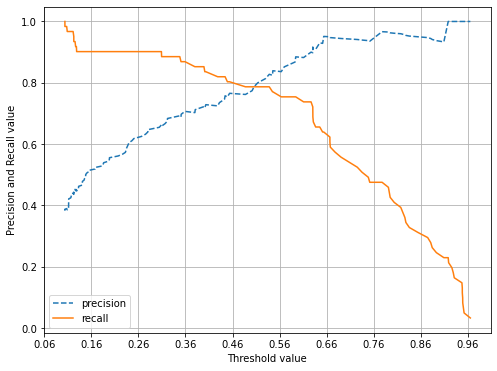

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

정밀도와 재현율은 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용해야 함<br>
단순히 하나의 성능 지표 수치를 높이기 위한 수단으로 사용되어서는 안 됨

# F1 Score

<b>f1_score()</b>
- 정밀도와 재현율을 결합한 지표
- 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐

F1 = 2*(precision x recall / (precision + recall)

In [18]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print('F1 Score: {0:4f}'.format(f1))

F1 Score: 0.780488


# ROC 곡선과 AUC

<b>ROC 곡선</b><br>
이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표<br>
- FPR(False Positive Rate)이 변할 때 TPR(재현율)이 어떻게 변화하는지 나타내는 곡선
- FPR을 X축으로, TPR을 Y축으로 잡음
- ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지고, 멀어질수록 뛰어난 것

cf) 민감도에 대응하는 지표 TNR(특이성)<br>
TNR: 실제 Negative가 정확히 예측되어야 하는 수준

<img src="https://46gyn61z4i0t1u1pnq2bbk2e-wpengine.netdna-ssl.com/wp-content/uploads/2018/07/ROC-curve-1.jpg" width="50%">

<b>roc_curve(y_true, y_score)</b>
- 파라미터<br>
y_true: 실제 클래스 값<br>
y_score: predict_proba()의 반환 값 array에서 Positive 칼럼의 예측 확률이 보통 사용됨
- 반환 값:
fpr, tpr, thresholds

In [19]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)

# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


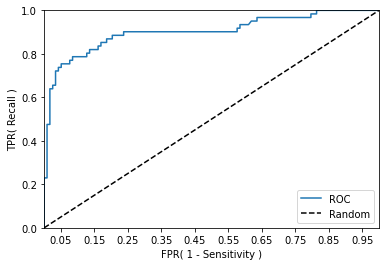

In [20]:
def roc_curve_plot(y_test , pred_proba_c1):
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    plt.plot(fprs , tprs, label='ROC')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

<b>AUC</b><br>
ROC 곡선 밑의 면적을 구한 것으로, 1에 가까울수록 좋은 수치

# 피마 인디언 당뇨병 예측

DATASET<br>
- Pregnancies: 임신 횟수
- Glucose
- BloodPressure
- SkinThickness: 삼두근 뒤쪽의 피하지방 측정값
- Insulin
- BMI
- DiabetesPredigreeFunctinon: 당뇨 내력 가중치 값
- Age
- Outcome: 클래스 결정 값(0 or 1)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


Negative의 양이 많음

In [22]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


결측치 없고 모두 숫자형 자료

In [26]:
def get_clf_eval(y_test , pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [27]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도0.7209, 재현율:0.5741, F1:0.6392, AUC:0.7919


C:\Users\tende\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


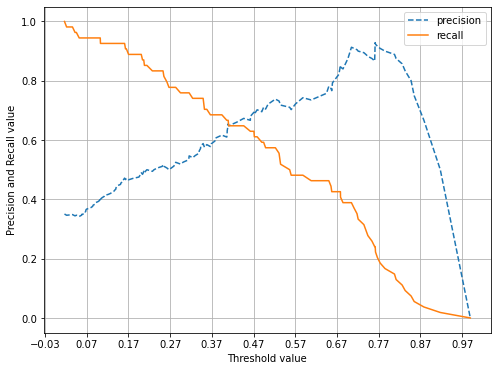

In [28]:
pred_proba_c1= lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [29]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min 수치가 0이 많은데 포도당이 0? 말안되죠

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

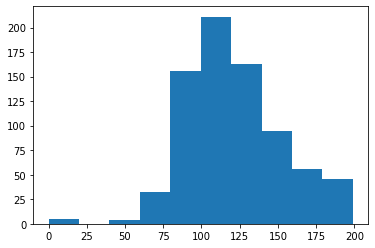

In [30]:
plt.hist(diabetes_data['Glucose'], bins=10)

In [33]:
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
total_count = diabetes_data['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f}%'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65%
BloodPressure 0 건수는 35, 퍼센트는 4.56%
SkinThickness 0 건수는 227, 퍼센트는 29.56%
Insulin 0 건수는 374, 퍼센트는 48.70%
BMI 0 건수는 11, 퍼센트는 1.43%


0값의 건수 및 전체 데이터 건수 대비 몇 퍼센트의 비율인지 확인

In [35]:
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, diabetes_data[zero_features].mean())

0 값을 평균값으로 대체

In [36]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

scaler = StandardScaler( )
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도0.7674, 재현율:0.6111, F1:0.6804, AUC:0.8433


0을 대체한 데이터 세트에 피처 스케일링 적용

In [39]:
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도0.5658, 재현율:0.7963, F1:0.6615, AUC:0.8433
임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도0.6000, 재현율:0.7778, F1:0.6774, AUC:0.8433
임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도0.6190, 재현율:0.7222, F1:0.6667, AUC:0.8433
임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도0.6333, 재현율:0.7037, F1:0.6667, AUC:0.8433
임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도0.6923, 재현율:0.6667, F1:0.6792, AUC:0.8433
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도0.7059, 재현율:0.6667, F1:0.6857, AUC:0.8433
임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도0.7447, 재현율:0.6481, F1:0.6931, AUC:0.8433
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도0.7674, 재현율:0.6111, F1:0.6804, AUC:0.8433


분류 결정 임곗값을 변화시키며 성능 수치 확인

In [40]:
binarizer = Binarizer(threshold=0.48)

pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1,1)) 
get_clf_eval(y_test , pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도0.7447, 재현율:0.6481, F1:0.6931, AUC:0.8433
